In [ ]:
import torch
import torchvision
from pathlib import Path

import cv2
import numpy as np


import random
from torchvision.transforms import v2 as T
from torchvision import datapoints

from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
import PIL
from PIL import Image

from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import math
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


!pip install torchmetrics
!pip install easyocr

import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 17.1 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# Set the device to use in all the notebook
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Reading data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Creation of a transformations class

In [ ]:
# Define a custom transformation class
class mytransform():
    def __init__(self, train = False):
        # Initialize the transform sequence using torchvision's Compose
        # The sequence includes resizing the image to 640x640 and applying a random horizontal flip with a 25% chance

        if train:
          self.transform = T.Compose([T.Resize((640, 640)),
                                    T.RandomHorizontalFlip(p=0.25),
                                    T.RandomVerticalFlip(p=0.25)])
        else:
          self.transform = T.Compose([T.Resize((640, 640))])

    # The __call__ method makes the class callable, so it can be used like a function
    def __call__(self, img, target):
        # Extract bounding box coordinates from the 'target' dictionary
        xmin = int(target['annotation']['object'][0]['bndbox']['xmin'])
        xmax = int(target['annotation']['object'][0]['bndbox']['xmax'])
        ymin = int(target['annotation']['object'][0]['bndbox']['ymin'])
        ymax = int(target['annotation']['object'][0]['bndbox']['ymax'])

        # Convert image to a tensor of type float32
        img = datapoints.Image(img, dtype=torch.float32)

        # Create a BoundingBox object with the extracted coordinates
        bounding_box = datapoints.BoundingBox([[xmin, ymin, xmax, ymax]],
                                              format=datapoints.BoundingBoxFormat.XYXY,
                                              spatial_size=F.get_spatial_size(img))

        # Move image and bounding box to the device (could be CPU or GPU)
        img, bounding_box = img.to(device), bounding_box.to(device)

        # Apply the previously defined transformations
        img, bounding_box = self.transform(img, bounding_box)

        #if random.random() < 0.25:
        #  color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        #  img = color_jitter(img)

        # Create a dictionary to hold additional target information
        d = {}
        d['image_id'] = target['annotation']['filename'][4:-4]
        d['boxes'] = bounding_box.type(torch.float32)
        d['labels'] = torch.Tensor([1]).to(dtype=torch.int64).to(device)

        return img, d  # Return the transformed image and the new target dictionary

# Custom collate function to prepare a batch for the DataLoader
def collate(batch):
    # Unzip the batch into images and targets
    img, target = list(zip(*batch))

    # Convert tuples to lists
    img, target = list(img), list(target)

    return img, target  # Return the lists as a new batch

# Instantiate the custom transform
transfrom_train = mytransform(train = True)

transform_test = mytransform(train = False)

In [ ]:
with open('/content/drive/MyDrive/Dataset/VOCdevkit/VOC2012/ImageSets/Main/train.txt', 'r') as read:
  print("len: train", len(read.readlines()))

with open('/content/drive/MyDrive/Dataset/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt', 'r') as read:
  print("len: val", len(read.readlines()))

with open('/content/drive/MyDrive/Dataset/VOCdevkit/VOC2012/ImageSets/Main/val.txt', 'r') as read:
  print("len: test", len(read.readlines()))

len: train 352
len: val 46
len: test 34


##Creation of the different data loaders

In [ ]:
# Initialize dataset
voc_dataset_train = VOCDetection(root='/content/drive/MyDrive/Vision and learning/Dataset',
                           year='2012',
                           image_set='train',  # Use 'val' for validation set
                           download=False,     # Set to True if you want to download the dataset
                           transforms=transfrom_train)

voc_dataset_val = VOCDetection(root='/content/drive/MyDrive/Vision and learning/Dataset',
                           year='2012',
                           image_set='trainval',  # Use 'val' for validation set
                           download=False,
                           transforms=transform_test)     # Set to True if you want to download the dataset

voc_dataset_test = VOCDetection(root='/content/drive/MyDrive/Vision and learning/Dataset',
                           year='2012',
                           image_set='val',  # Use 'val' for validation set
                           download=False,     # Set to True if you want to download the dataset
                           transforms=transform_test)

train_loader = DataLoader(voc_dataset_train, batch_size=1, shuffle=True, collate_fn=collate)

val_loader   = DataLoader(voc_dataset_val,   batch_size=4, shuffle=False,  collate_fn=collate)

test_loader  = DataLoader(voc_dataset_test,  batch_size=4, shuffle=False, collate_fn=collate)

##Definition and training of our model

In [ ]:
def get_model_object_detection():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained = False)
  num_classes = 2  # 1 class (licens plate) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
# Load the model
model = get_model_object_detection()
model = model.to(device) # Model to device

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler=None):
    model.train()
    lr_scheduler = None
    inference_timer = []
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    loss = 0
    inference_time = 0
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch}"):
        with torch.cuda.amp.autocast(enabled=scaler is not None):
          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            sys.exit(1)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()

        loss += loss_value
        if lr_scheduler is not None:
            lr_scheduler.step()

    avg_loss = loss / len(data_loader.dataset)
    print(f"Train loss: {avg_loss}")
    return avg_loss


def validate(model, val_data_loader,  scaler=None):
  total_loss = 0
  inference_time = 0  # Track inference time
  inference_timer_val = []
  with torch.no_grad():

      for images, targets in tqdm(val_data_loader):

          with torch.cuda.amp.autocast(scaler is not None):
            start_event = torch.cuda.Event(enable_timing=True)  # Create start event
            end_event = torch.cuda.Event(enable_timing=True)  # Create end event
            start_event.record()  # Record start time
            loss_dict = model(images, targets)
            end_event.record()  # Record end time
            torch.cuda.synchronize()  # Wait for GPU operations to complete
            inference_time += start_event.elapsed_time(end_event) / 1000.0  # Accumulate inference time in millisecond
            losses = sum(loss for loss in loss_dict.values())

          loss_value = losses.item()
          total_loss += loss_value


  avg_loss = total_loss / len(val_data_loader.dataset)
  avg_inference_time_per_image = inference_time / len(val_data_loader.dataset)
  inference_timer_val.append(avg_inference_time_per_image)
  print(f"Average Inference Time per Image (Validation): {avg_inference_time_per_image:.5f} seconds")
  print(f"Validation loss: {avg_loss}")

  return avg_loss, inference_timer_val


Epoch 0:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 1.194612348790873


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.12307 seconds
Validation loss: 0.25414009327473847


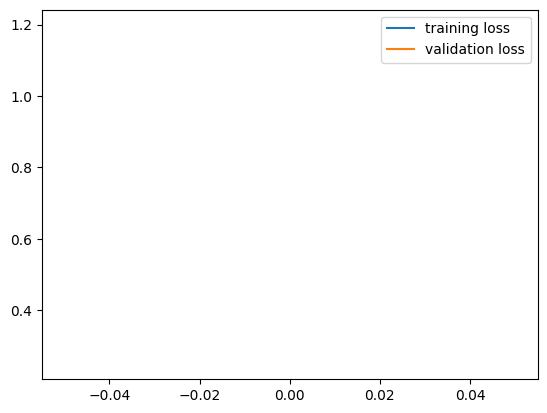

Epoch 1:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.8633629393509843


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10922 seconds
Validation loss: 0.21728140374888544


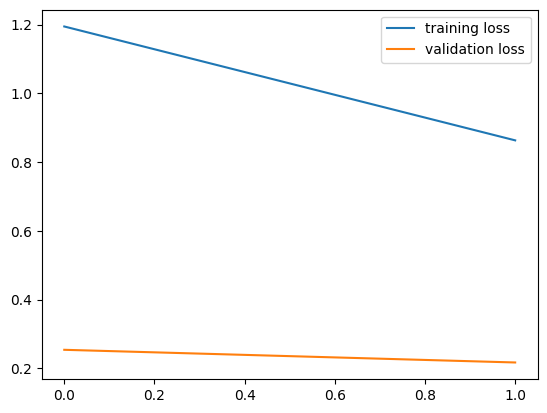

Epoch 2:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7927932207557288


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10949 seconds
Validation loss: 0.20590141026870065


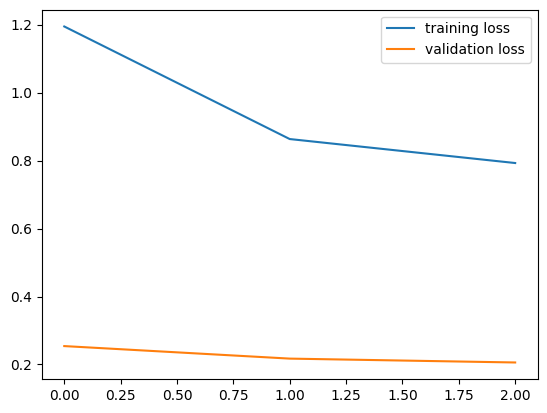

Epoch 3:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7669948998161338


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10960 seconds
Validation loss: 0.20041586393895355


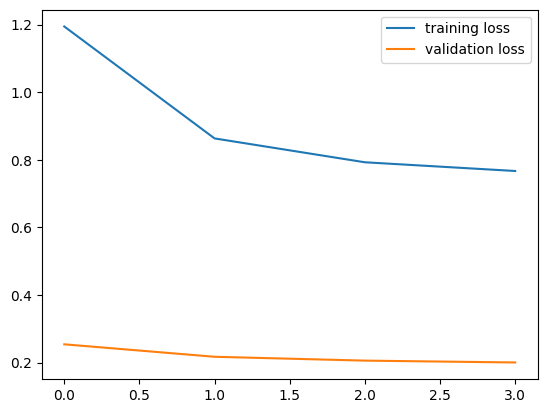

Epoch 4:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7508618091656403


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11000 seconds
Validation loss: 0.19507594212241794


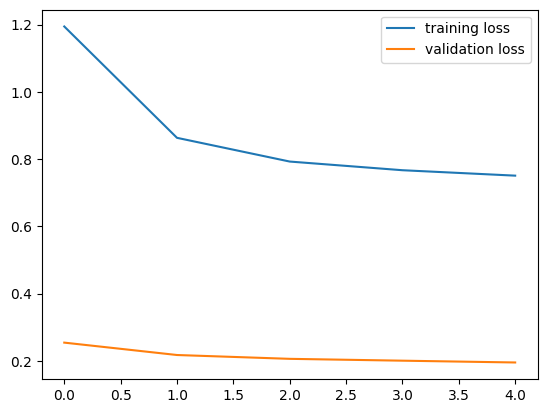

Epoch 5:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7451179295100949


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11025 seconds
Validation loss: 0.19511050115460934


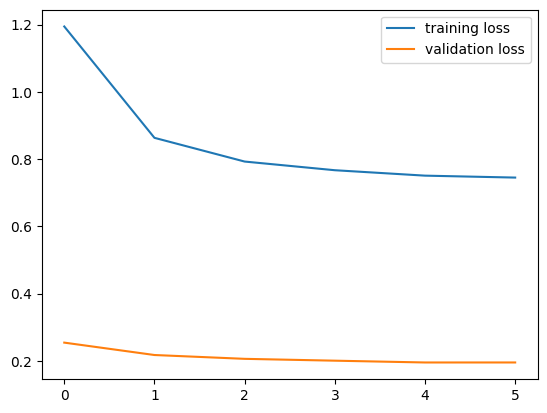

Epoch 6:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7429944283582948


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11024 seconds
Validation loss: 0.1946685625159222


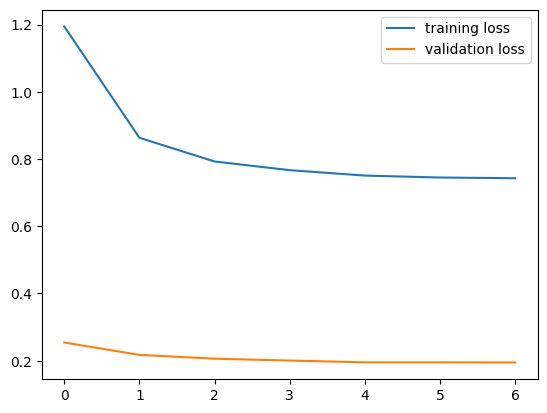

Epoch 7:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7427791590717706


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11063 seconds
Validation loss: 0.19441335097603177


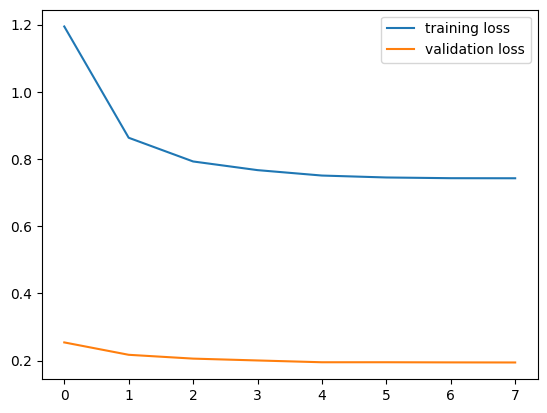

Epoch 8:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7415767823430625


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11024 seconds
Validation loss: 0.1940260931201603


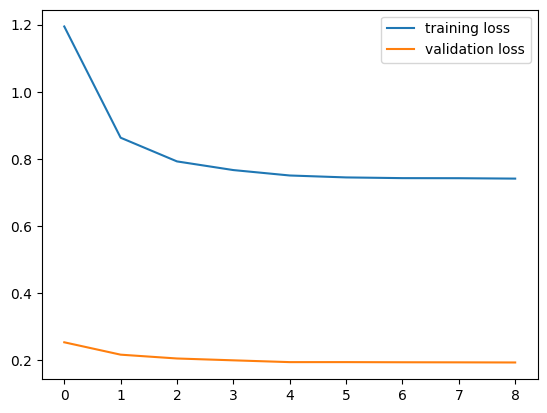

Epoch 9:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7402749178423123


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10968 seconds
Validation loss: 0.19395146033038263


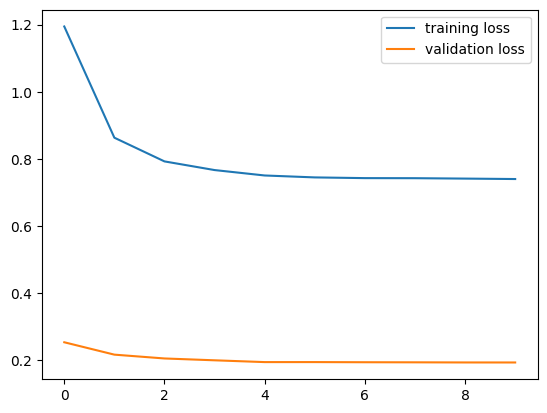

Epoch 10:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7386772593652661


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11000 seconds
Validation loss: 0.19369498024816098


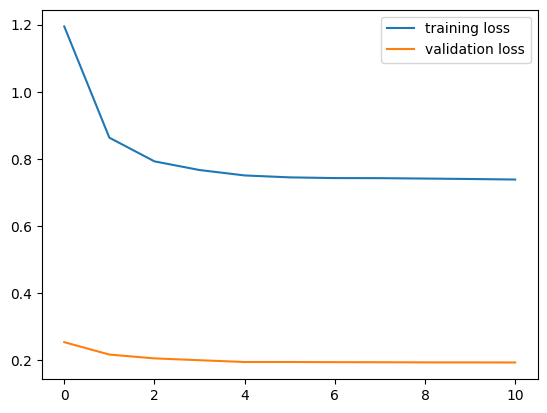

Epoch 11:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7386331468481909


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11005 seconds
Validation loss: 0.19396252994951996


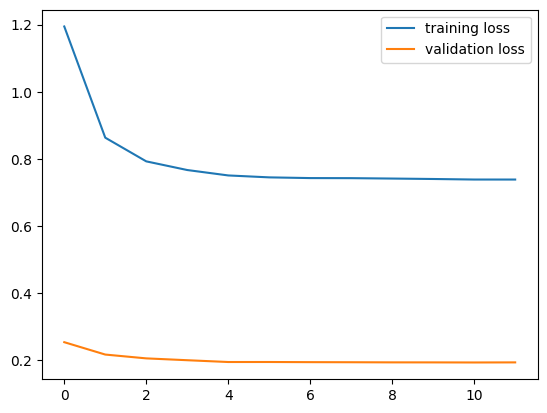

Epoch 12:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7376215573061596


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11108 seconds
Validation loss: 0.1936912899431975


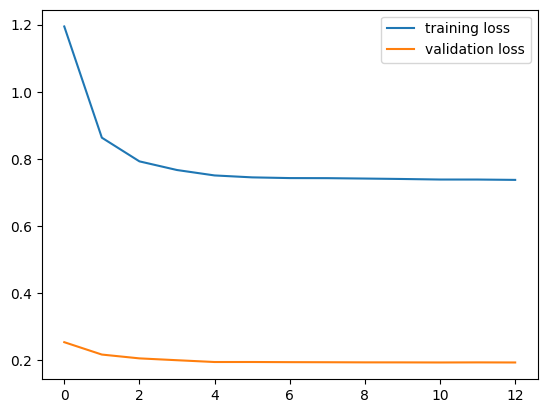

Epoch 13:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7381584263322029


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11062 seconds
Validation loss: 0.19382164918858072


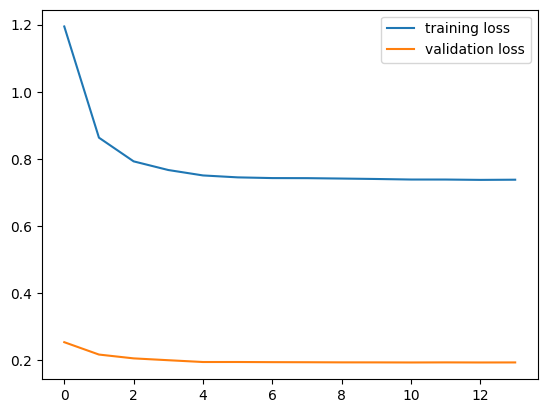

Epoch 14:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7373500820249319


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11082 seconds
Validation loss: 0.1936330354732016


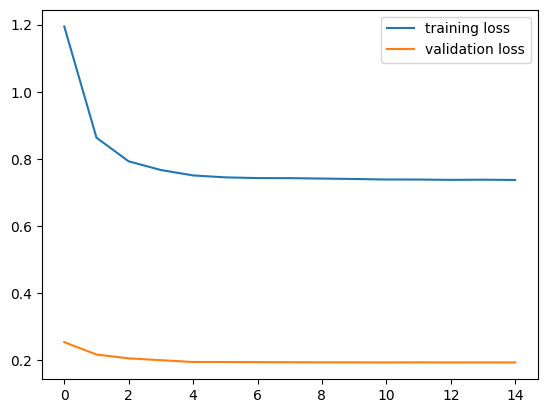

Epoch 15:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7382401969622482


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11033 seconds
Validation loss: 0.1936972931675289


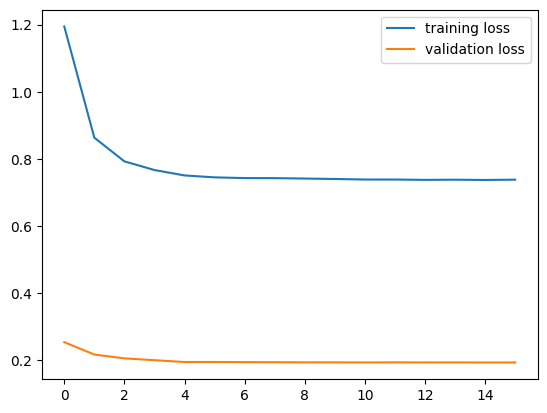

Epoch 16:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7385227668353103


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10938 seconds
Validation loss: 0.19364348183507504


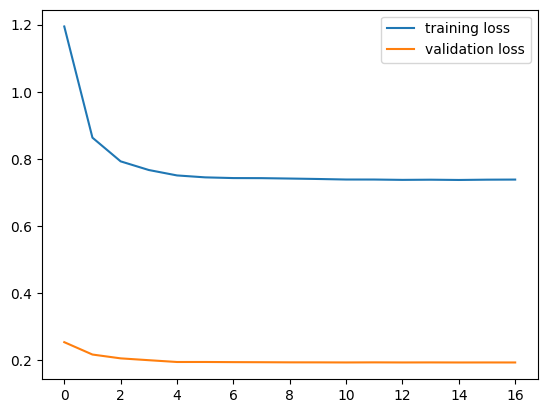

Epoch 17:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.735738780349493


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10960 seconds
Validation loss: 0.1937055678471275


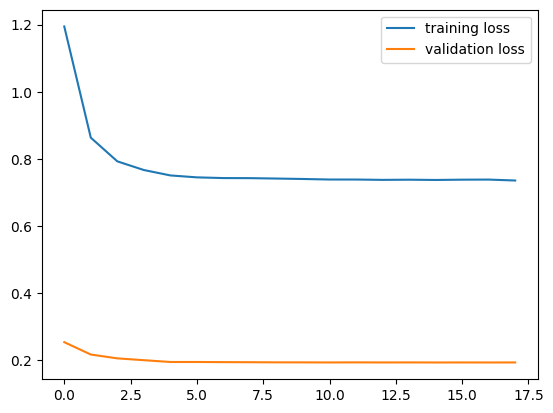

Epoch 18:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7375830210406672


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.11004 seconds
Validation loss: 0.193617881640144


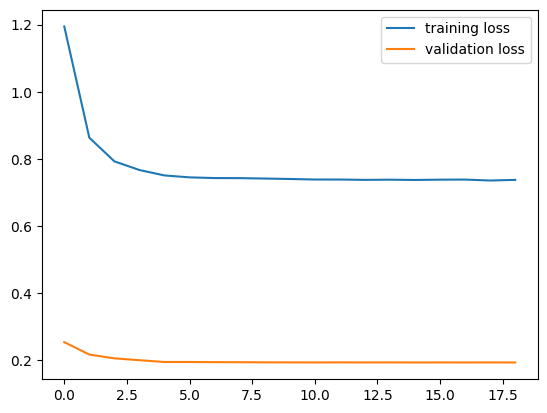

Epoch 19:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7374963992359963


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10946 seconds
Validation loss: 0.19355401526326718


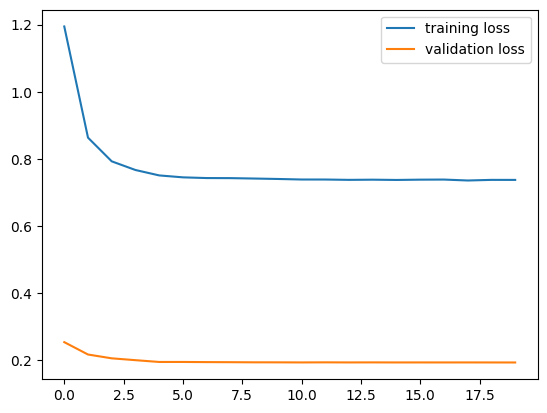

Epoch 20:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7369484850628809


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10891 seconds
Validation loss: 0.1937000194321508


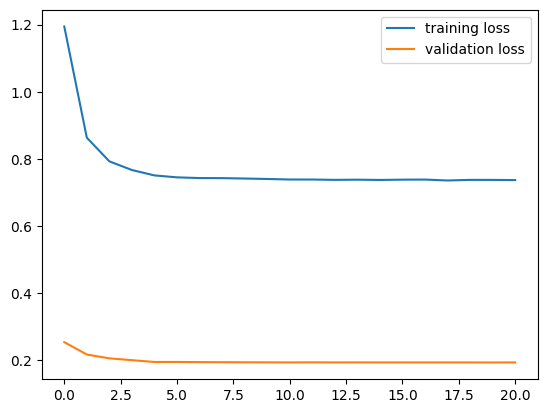

Epoch 21:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7374786768447269


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10938 seconds
Validation loss: 0.19361208184905673


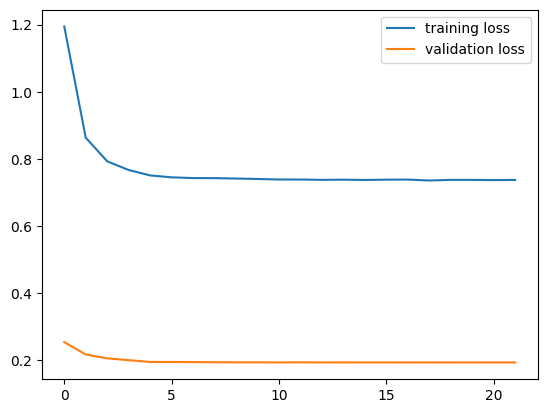

Epoch 22:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7374190623787317


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10870 seconds
Validation loss: 0.19371935466061468


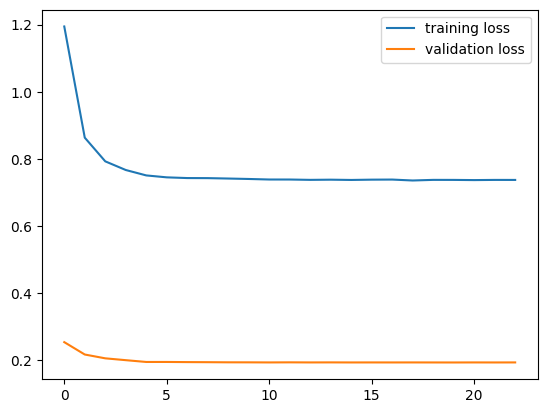

Epoch 23:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7378611165014181


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10935 seconds
Validation loss: 0.19366155759147977


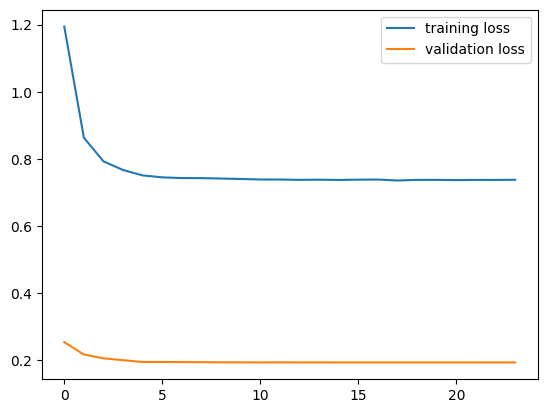

Epoch 24:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7382452122189782


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10884 seconds
Validation loss: 0.19366751028143842


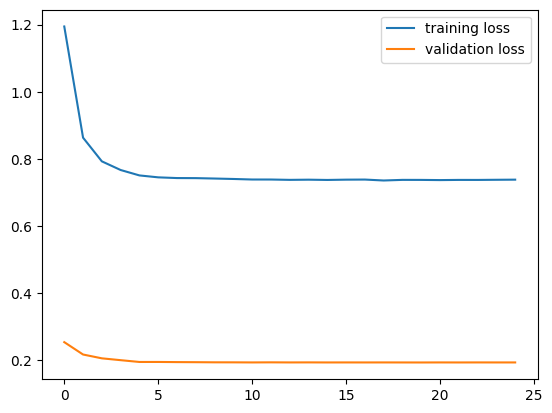

Epoch 25:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7380371498451992


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10917 seconds
Validation loss: 0.19360437989234924


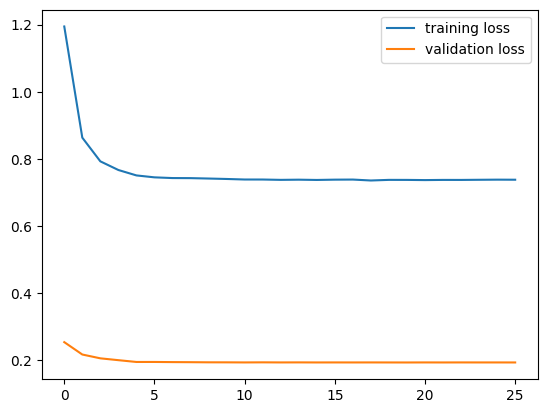

Epoch 26:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7367387813600627


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10932 seconds
Validation loss: 0.19363823403482852


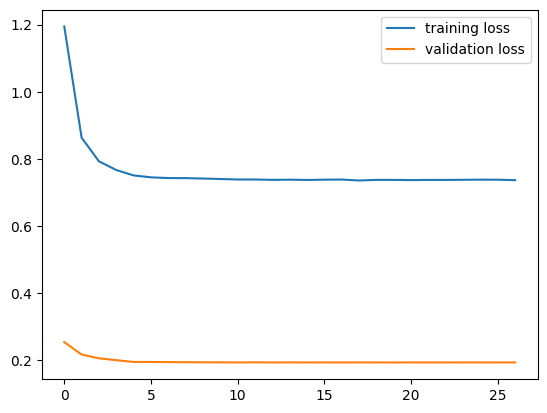

Epoch 27:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7390830139206215


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10940 seconds
Validation loss: 0.19358585969261502


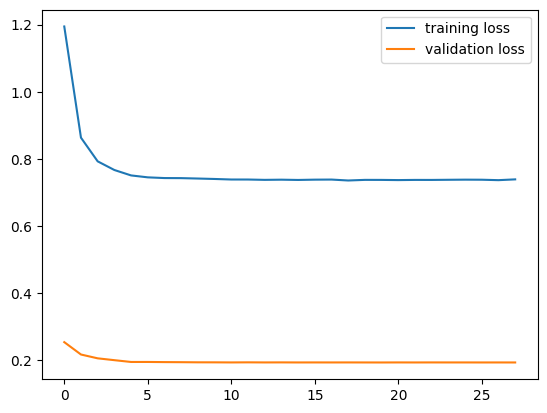

Epoch 28:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.7378805564208464


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10914 seconds
Validation loss: 0.19363591593244803


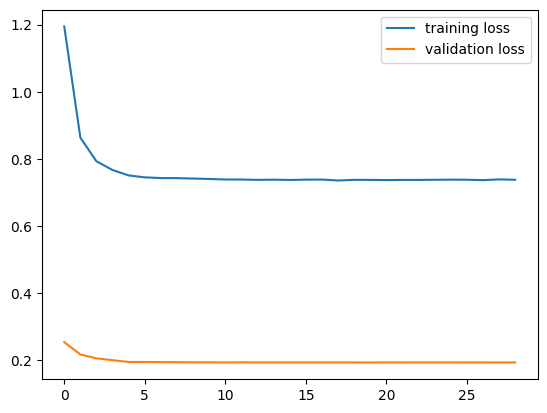

Epoch 29:   0%|          | 0/352 [00:00<?, ?it/s]

Train loss: 0.738165401599624


  0%|          | 0/12 [00:00<?, ?it/s]

Average Inference Time per Image (Validation): 0.10939 seconds
Validation loss: 0.1937335314957992


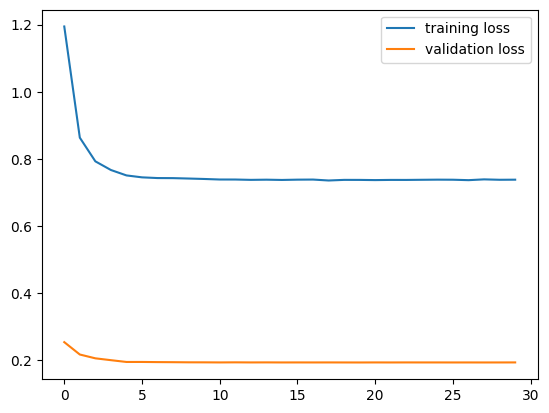

That's it!


In [ ]:
num_epochs = 30

losses = {'train':[], 'val':[]}

max_validation = -1
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    avg_loss_value_train = train_one_epoch(model, optimizer, train_loader, device, epoch)
    avg_loss_value_validation, inference_time_val = validate(model, val_loader)

    if avg_loss_value_validation > max_validation:
      max_validation = avg_loss_value_validation
      best_model = model

    # update the learning rate
    lr_scheduler.step()

    losses['train'].append(avg_loss_value_train)
    losses['val'].append(avg_loss_value_validation)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

model = best_model
print("That's it!")

In [ ]:
torch.save(model,"/content/drive/MyDrive/Vision and learning/no_pretrain_FRCNN_30e_2.pth")

## EVALUATION

In [ ]:
model = torch.load("/content/drive/MyDrive/Vision and learning/pretrain_FRCNN_30e_2.pth")

In [ ]:
@torch.inference_mode()
def qualitative_results(model, data_loader):
  """
  Function used to calculate all the bounding boxes in the test set
  """
  results = []
  not_predicted = []

  model.eval()
  epoch = 0
  for images, targets in tqdm(data_loader, desc=f"Epoch {epoch}"):
    predictions = model(images)
    epoch += 1
    for idx, pred in enumerate(predictions):
      prediction = {}

      if len(pred['scores']) == 0:
        not_predicted.append(targets[idx]['image_id'])
        continue
      best_indice = torch.where(pred['scores'] == torch.max(pred['scores']))
      best_boundig_boxs = pred['boxes'][best_indice]
      scores = torch.tensor(pred['scores'][best_indice])

      prediction['filename'] = targets[idx]['image_id']
      prediction['image'] = images[idx]
      prediction['boxes'] = best_boundig_boxs
      prediction['scores'] = torch.tensor(pred['scores'][best_indice])
      prediction['labels'] = torch.tensor([1])

      results.append(prediction)

  return results, not_predicted

def get_target(data_loader, not_predicted):
  """
  Function used to obtain the ground truth of the test set
  """
  target = []
  for image, bbox in data_loader:
    for tar in bbox:
      if tar['image_id'] in not_predicted:
        continue

      predicted = {}
      predicted['filename'] = tar['image_id']
      predicted['boxes'] = tar['boxes']
      predicted['labels'] = torch.tensor([1])
      target.append(predicted)
  return target

In [ ]:
# Obtain the predicted bounding boxes
preds, not_predicted = qualitative_results(model, test_loader)

# Obtain the ground truth bounding boxes
target = get_target(test_loader, not_predicted)

In [ ]:
# Load the function to evaluate the results
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, target)
from pprint import pprint
pprint(metric.compute())

{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.5382),
 'map_50': tensor(0.8575),
 'map_75': tensor(0.4982),
 'map_large': tensor(0.6519),
 'map_medium': tensor(0.5157),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.),
 'mar_1': tensor(0.6118),
 'mar_10': tensor(0.6118),
 'mar_100': tensor(0.6118),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.7273),
 'mar_medium': tensor(0.5818),
 'mar_small': tensor(0.)}


##Character Recognition

In [ ]:
!pip install keras-ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
JPEGImages = Path('/content/drive/MyDrive/Vision and learning/Dataset/VOCdevkit/VOC2012/JPEGImages')
Frontal = Path('/content/drive/MyDrive/Vision and learning/test_images/Test/Test/Frontal/Frontal')
Lateral = Path('/content/drive/MyDrive/Vision and learning/test_images/Test/Test/Lateral/Lateral')


Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
[[('2153gyx', array([[2418.5615 ,  981.33154],
       [3026.8054 ,  967.1862 ],
       [3030.728  , 1135.8582 ],
       [2422.4841 , 1150.0035 ]], dtype=float32)), ('e', array([[2334.9375, 1098.5625],
       [2382.1875, 1098.5625],
       [2382.1875, 1157.625 ],
       [2334.9375, 1157.625 ]], dtype=float32))]]
Largest Text: 2153gyx
Largest Bounding Box: [[2418.5615   981.33154]
 [3026.8054   967.1862 ]
 [3030.728   1135.8582 ]
 [2422.4841  1150.0035 ]]


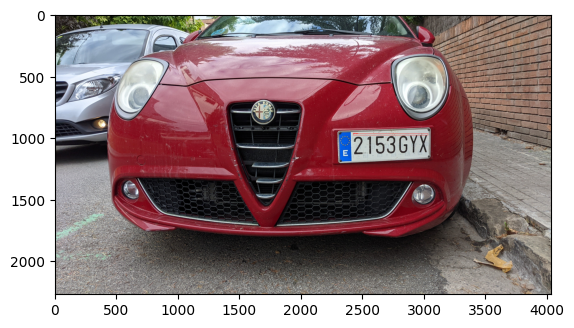

In [ ]:
import keras_ocr
import numpy as np
import PIL
from PIL import Image, ImageDraw, ImageFont

def detect_license_plate(keras_ocr_pipeline, Frontal, number, image_name=None):
    if image_name is not None:
        image_path = Frontal / image_name

    img = PIL.Image.open(image_path)
    image_numpy = np.array(img)

    # Perform OCR using Keras OCR
    predictions = keras_ocr_pipeline.recognize([image_numpy])
    print(predictions)

    # Initialize variables to keep track of the largest text and its associated bounding box
    largest_text = ""
    largest_bbox = None
    largest_text_length = 0

    # Iterate through the detected text regions and find the largest text
    for text, bbox in predictions[0]:
        # Check if this text is longer than the current largest
        if len(text) > largest_text_length:
            largest_text = text
            largest_bbox = bbox
            largest_text_length = len(text)

    # Draw bounding box and text on the image
    draw = ImageDraw.Draw(img)
    draw.rectangle([tuple(largest_bbox[0]), tuple(largest_bbox[1])], outline="red", width=2)

    # Define a font for the text
    font = ImageFont.load_default()

    # Calculate text position
    text_x = largest_bbox[0][0]
    text_y = largest_bbox[0][1] - 20  # Adjust this value to change text position

    # Draw the text on the image
    draw.text((text_x, text_y), largest_text, fill="red", font=font)

    return img, largest_text, largest_bbox

# Load the Keras OCR pipeline
keras_ocr_pipeline = keras_ocr.pipeline.Pipeline()

# Usage example:
image, text, bounding_box = detect_license_plate(keras_ocr_pipeline, Frontal, number=0, image_name="2153GYX.jpg")

print("Largest Text:", text)
print("Largest Bounding Box:", bounding_box)


In [ ]:
def detect_licensplate(model, JPEGImages, number, image_name = None):
  if image_name is not None:
    image_name = JPEGImages / image_name
  else:
    image_name = 'Cars' + target[number]['filename'] + '.jpg'

  img = PIL.Image.open(JPEGImages / image_name)
  original_size = img.size

  # resize the image as we did during training and convert it to the new Image type of torchvision
  img_resize = transform_test.transform(img)
  Image = datapoints.Image(img_resize, dtype=torch.float32)

  model.eval()
  with torch.no_grad():
      # convert RGBA -> RGB and move to device
      Image = Image[:3, ...].to(device)
      predictions = model([Image, ])
      pred = predictions[0]

  best_scores = torch.where(pred['scores'] > 0.65)
  pred = pred['boxes'][best_scores]

  return Image, pred

def easy_ocr(image: torch.Tensor, bounding_box: torch.Tensor):
  #Rearrange the dimensions of the tensor
  image = image.permute(1, 2, 0)
  # Pass the image to numpy, transform it to a pil image and then croped the part of the licens plate
  image_numpy = image.cpu().numpy().astype(np.uint8)

  # Image to PIL.Image
  pil_image = Image.fromarray(image_numpy)

  #Repeat the process for the coordinates
  xmin, ymin, xmax, ymax = bounding_box.long().cpu().numpy()[0]

  # Cropped the PIL image using the cordinates
  cropped_image = pil_image.crop((xmin, ymin, xmax, ymax))

  # Pass the image trought the OCR
  numpy_image = np.array(cropped_image)
  predictions = reader.readtext(numpy_image, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
  #predictions = pipeline.recognize([numpy_image])

  predicted_text = predictions[0][-2]

  return pil_image, predicted_text, (xmin, ymin, xmax, ymax)

In [ ]:
# Caller function of the other ones. Has the same signature as the detect_licensplate function
def licens_plate_recognizer(model, folder_images, number_image = 0, name_image = None):
  image, bounding_box = detect_licensplate(model, folder_images, number_image, name_image)
  pil_image, predicted_text, bounding_box = easy_ocr(image, bounding_box)

  return pil_image, bounding_box, predicted_text

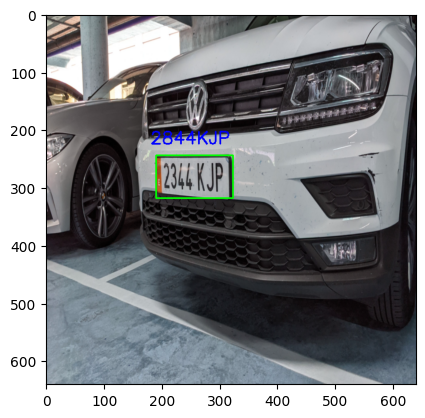

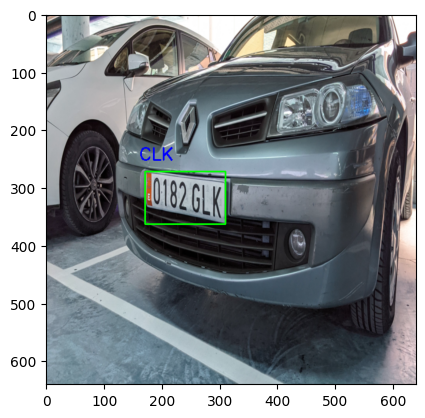

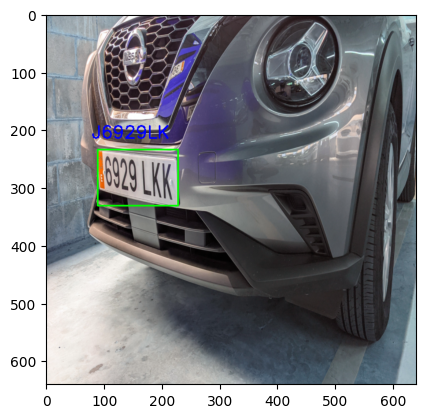

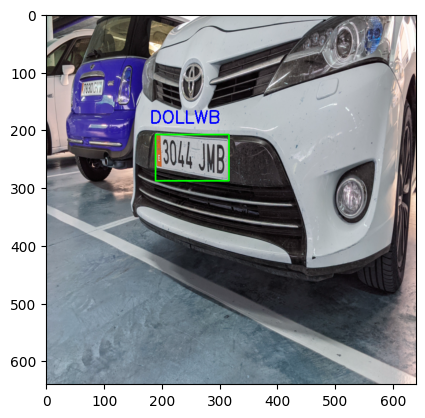

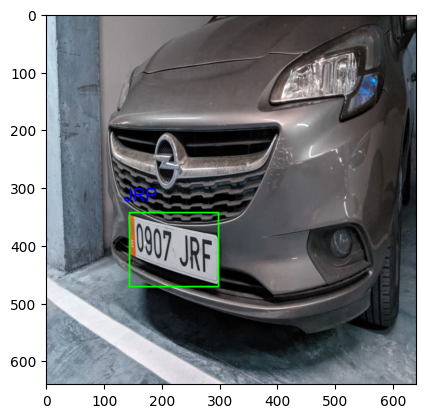

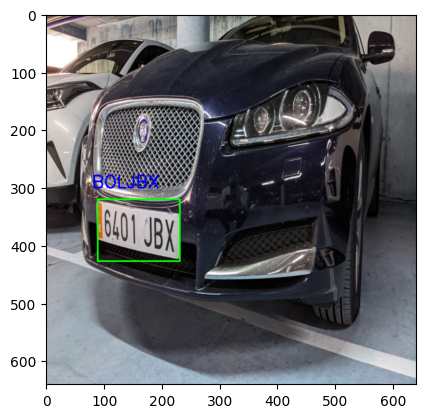

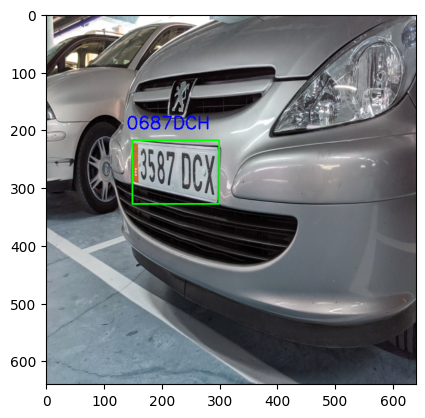

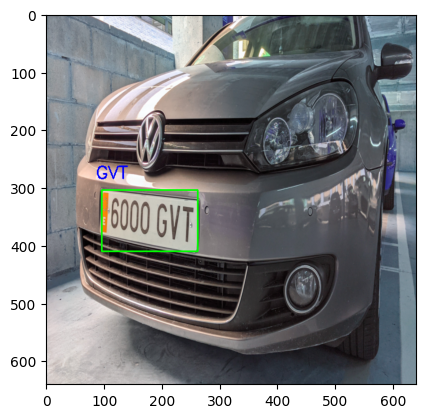

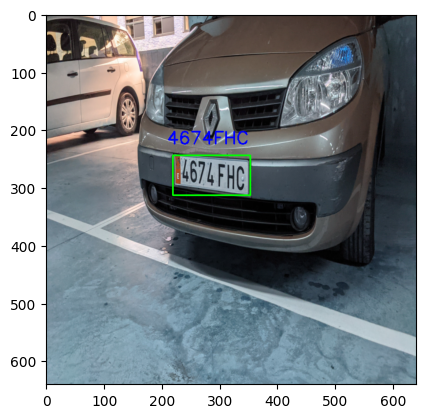

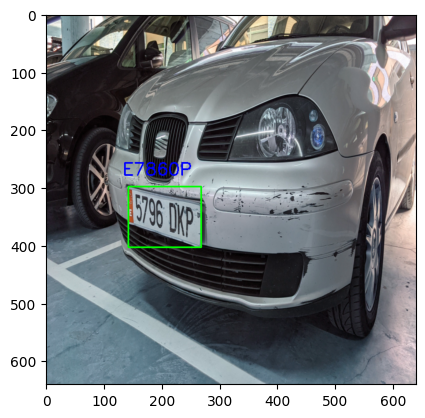

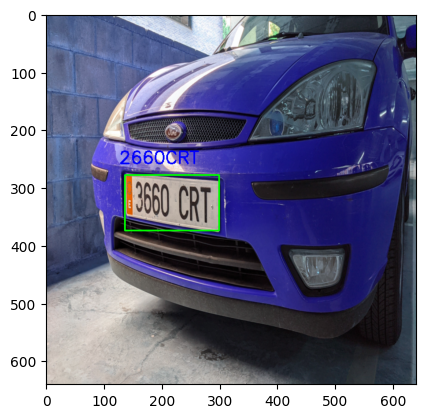

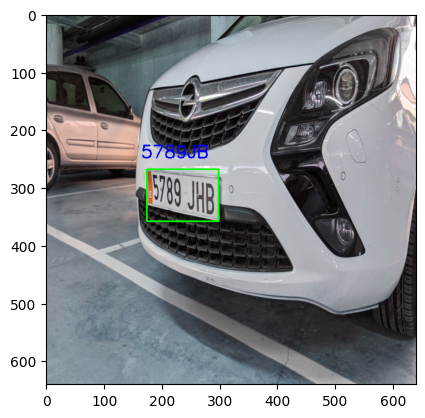

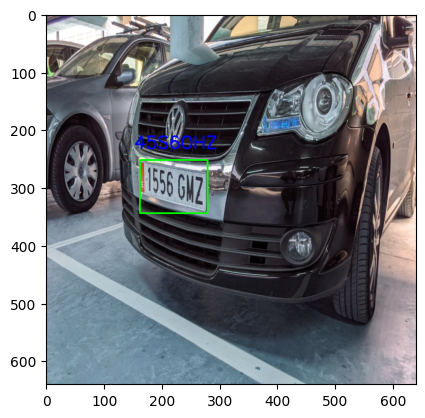

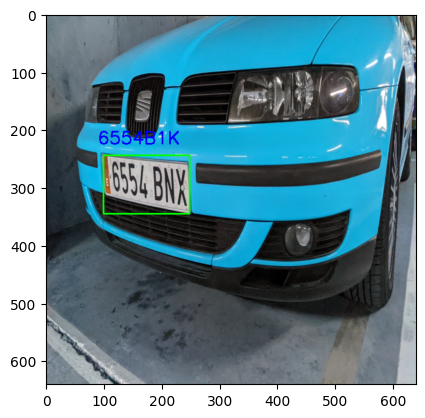

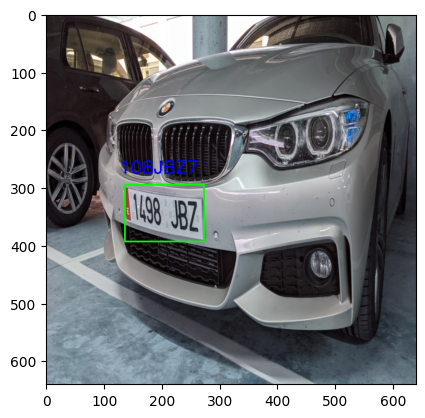

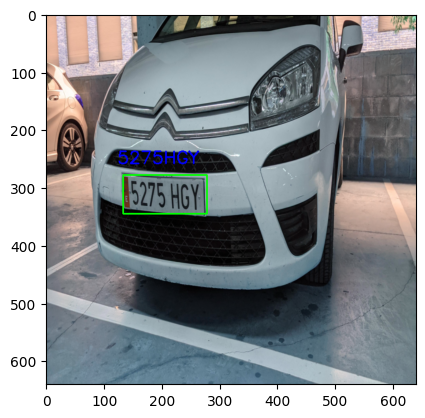

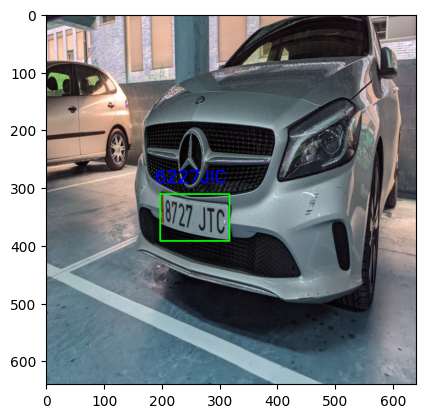

In [ ]:
for image_path in Lateral.iterdir():
    # Check if the path is a file
    if image_path.is_file():
        # Get the file name
        image_name = image_path.name

        # Call the license plate recognizer for each image
        pil_image, bounding_box, predicted_text = licens_plate_recognizer(model, Lateral, number_image=0, name_image=image_name)

        # Load your image (assuming 'image' is your image as a NumPy array)
        image = np.array(pil_image)

        # Create a copy of the image to draw on
        output_image = image.copy()

        text = [predicted_text[:7]]
        cordinates = [bounding_box]

        # Iterate through the bounding boxes and text predictions
        for bbox, text in zip(cordinates, text):
            # Convert coordinates to integers
            xmin, ymin, xmax, ymax = bbox

            # Draw the bounding box
            cv2.rectangle(output_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green rectangle

            # Add the predicted text near the bounding box
            cv2.putText(output_image, text, (xmin - 10, ymin - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)  # Red text

        # Display the image with bounding boxes and text
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.show()

Frontal images:
-- Detected: 15/15

-- Correct character: 8/15 (only numbers 13/15)

Lateral images:
-- Detected: 17/17

-- Correct character: 2/17

## Calculating flops and gmacs

In [ ]:
 #Load the model
model = torch.load('/content/drive/MyDrive/Vision and learning/pretrain_FRCNN_30e_2.pth')

In [ ]:
!pip install ptflops
from ptflops import get_model_complexity_info
import re

macs, params = get_model_complexity_info(model, (3, 640, 640), as_strings=True,
                                        print_per_layer_stat=True, verbose=True)
# Extract the numerical value
flops = eval(re.findall(r'([\d.]+)', macs)[0])*2

# Extract the unit
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]
print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))

  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7-py3-none-any.whl size=11075 sha256=627b9f6b1023fb2e17ee9e0476ee7871ddd00b0d36a664ccdec67005ea4b9b8d
  Stored in directory: /root/.cache/pip/wheels/b9/54/3b/f84523431ce82e08462644d279c0e13a51a00236e237e6bc7e
Successfully built ptflops
FasterRCNN(
  43.03 M, 100.000% Params, 280.59 GMac, 100.000% MACs, 
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    26.63 M, 61.884% Params, 88.85 GMac, 31.666% MACs, 
    (body): IntermediateLayerGetter(
      23.28 M, 54.107% Params, 52.55 GMac, 18.728% MACs, 
      (conv1): Conv2d(0, 0.000% Params, 1.51 GMac, 0.536% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(0, 0.000% Params, 20.48 MMac, 0.007% MACs, 64, eps=1e-05, momentum=0.1, affine=True, tr